In [312]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

import xgboost as xgb
import lightgbm as lgbm
import pandas as pd
import numpy as np
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [313]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

In [314]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    # Replace each value by the according smoothed mean
    return smooth

In [315]:
train['Target'] = (train.Stage=='Closed Won').astype(int)
aux = train.drop_duplicates(subset=['Opportunity_ID'])
#calc_smooth_mean(aux, 'Opportunity_Owner', 'Target', 300)
#calc_smooth_mean(aux, 'Region', 'Target', 300)
#op = aux.groupby(['Opportunity_Owner', 'Region']).agg({'Target':['mean', 'count']})
#op.columns = ['prob_appr', 'opps_owned']
#op.nlargest(50, 'opps_owned')

In [316]:
train.drop(columns=['Source ', 'Prod_Category_A', 'Actual_Delivery_Date',\
                 'Last_Activity', 'Currency', 'Price', 'Product_Category_B',\
                 'Size', 'Product_Type', 'Brand'], inplace=True)
test.drop(columns=['Source ', 'Prod_Category_A', 'Actual_Delivery_Date',\
                 'Last_Activity', 'Currency', 'Price', 'Product_Category_B',\
                 'Size', 'Product_Type', 'Brand'], inplace=True)

train['Total_Amount_Sum'] = train.groupby('Opportunity_ID')['Total_Amount'].transform('sum')
test['Total_Amount_Sum'] = test.groupby('Opportunity_ID')['Total_Amount'].transform('sum')

train['ASP_sum_per_Opportunity'] = train.groupby('Opportunity_ID')['ASP'].transform('sum')
train['ASP_converted_sum_per_Opportunity'] = train.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
train['Convertibility']=train['ASP_converted_sum_per_Opportunity'] / train['ASP_sum_per_Opportunity']
test['ASP_sum_per_Opportunity'] = test.groupby('Opportunity_ID')['ASP'].transform('sum')
test['ASP_converted_sum_per_Opportunity'] = test.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
test['Convertibility']=test['ASP_converted_sum_per_Opportunity'] / test['ASP_sum_per_Opportunity']

train['Total_Amount_USD'] = train['Convertibility']*train['Total_Amount']
train['Total_Amount_Sum_USD'] = train['Convertibility']*train['Total_Amount_Sum']
train['Total_Taxable_Amount_USD'] = train['Convertibility']*train['Total_Taxable_Amount']
test['Total_Amount_USD'] = test['Convertibility']*test['Total_Amount']
test['Total_Amount_Sum_USD'] = test['Convertibility']*test['Total_Amount_Sum']
test['Total_Taxable_Amount_USD'] = test['Convertibility']*test['Total_Taxable_Amount']

#train.drop(columns = ['ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity',\
#                   'Total_Amount', 'Total_Taxable_Amount', 'Total_Amount_Sum',\
#                   'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Account_Name', 'Opportunity_Name', 'Sales_Contract_No'], inplace=True)
#test.drop(columns = ['ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity',\
#                   'Total_Amount', 'Total_Taxable_Amount', 'Total_Amount_Sum',\
#                   'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Account_Name', 'Opportunity_Name', 'Sales_Contract_No'], inplace=True)

train = train.loc[(train['Stage']=='Closed Won') | (train['Stage']=='Closed Lost')]

In [317]:
train.Territory.nunique()

75

In [318]:
def acomodar_territorios(df):
    lista_reg = []
    lista_ter = []

    for comb in (df.Region + '-' + df.Territory):
        reg, ter = comb.split('-')
        lista_reg.append(reg)

        if ter == 'Japan':
            lista_ter.append('Japan')
        else:
            lista_ter.append(ter)
    
    df.Region = lista_reg
    df.Territory = lista_ter

In [319]:
top10 = train.groupby('Opportunity_Owner').agg({'Opportunity_ID':'nunique'}).reset_index()
top10 = top10.nlargest(10, 'Opportunity_ID')
top = top10.Opportunity_Owner.to_list()

def isTop10(serie):
    lista = []
    
    for i in serie:
        if i in top:
            lista.append(True)
        else:
            lista.append(False)
    return lista

#train.Region.value_counts()
#aaa = test.loc[:, ['Region', 'Territory']]
#asd = train.loc[:, ['Region', 'Territory', 'Billing_Country']]
#asd
#display(asd[asd.Region=='APAC'].Billing_Country.value_counts())
#aaa[aaa.Region=='APAC'].Territory.value_counts()
#train.dtypes

In [320]:
def pricing_delivery(df):
    
    modif = []
    modif1 = []
    
    for amount in df.Total_Amount_Sum_USD:
        if amount<=200000:
            modif.append('Menor 200 mil')
        else:
            modif.append('Mayor 200 mil')

    for term in df.Delivery_Terms:
        if (term=='Delivery_Terms_0') | (term=='Delivery_Terms_3') | (term=='Delivery_Terms_5')| (term=='Delivery_Terms_6') | (term=='Delivery_Terms_7') | (term=='Delivery_Terms_8'):
            modif1.append('Other_Delivery_Terms')
        else:
            modif1.append(term)
    
    df['Price_Range'] = modif
    df['Delivery_Terms_Aux'] = modif1
    
    df['Pricing_Delivery'] = df.Price_Range + ' - ' + df.Delivery_Terms_Aux
        
def hasService(x):
    
    for t in x:
        if t==0:
            return True
    
    return False  

In [321]:
def set_df(df):
    
    df.Opportunity_Created_Date = pd.to_datetime(df.Opportunity_Created_Date, errors='coerce')
    df.Planned_Delivery_Start_Date = pd.to_datetime(df.Planned_Delivery_Start_Date, errors='coerce')
    df.Planned_Delivery_End_Date = pd.to_datetime(df.Planned_Delivery_End_Date, errors='coerce')
    df.Account_Created_Date = pd.to_datetime(df.Account_Created_Date, errors='coerce')
    df.Last_Modified_Date = pd.to_datetime(df.Last_Modified_Date, errors='coerce')

    #Date features (4)
    
    df['Created_Last_Act_Diff'] = df.Last_Modified_Date - df.Opportunity_Created_Date
    df.Created_Last_Act_Diff = df.Created_Last_Act_Diff.astype('timedelta64[D]')
    
    df['Last_Act_Over_End_Date'] = df.Planned_Delivery_End_Date - df.Last_Modified_Date
    df.Last_Act_Over_End_Date = df.Last_Act_Over_End_Date.astype('timedelta64[D]')
    
    df['Last_Act_Over_Start_Date'] = df.Last_Modified_Date - df.Planned_Delivery_Start_Date
    df.Last_Act_Over_Start_Date = df.Last_Act_Over_Start_Date.astype('timedelta64[D]')
    
    df['Last_Activity_In_Time'] = ((df.Last_Modified_Date > df.Planned_Delivery_Start_Date)&(df.Last_Modified_Date<df.Planned_Delivery_End_Date)).astype('int')
    
    df['Wait_Time_Days'] = df.Planned_Delivery_Start_Date - df.Opportunity_Created_Date
    df.Wait_Time_Days = df.Wait_Time_Days.astype('timedelta64[D]')
    
    df['Quote_Type'] = (df.Quote_Type == 'Non Binding').astype('int')
    
    df['Delivery_Window'] = df.Planned_Delivery_End_Date - df.Planned_Delivery_Start_Date
    df.Delivery_Window = df.Delivery_Window.astype('timedelta64[D]')
    
    df['Wait_Delivery_Cmp'] = df.Wait_Time_Days / df.Delivery_Window
    
    df['Delivered_Hot_Season'] = ((((df.Region=='EMEA')|(df.Region=='Americas')|(df.Region=='Japan')|\
                                   ((df.Region=='APAC')&(df.Territory!='Australia')))\
                                      &\
                                 ((df.Delivery_Quarter=='Q2')|(df.Delivery_Quarter=='Q3')))\
                                      |
                                 ((df.Territory=='Australia')&((df.Delivery_Quarter=='Q1')|(df.Delivery_Quarter=='Q4'))))

    df['USD_Per_Day_Waited'] = df.Total_Amount_Sum_USD/df.Wait_Time_Days
    
    max = df.Account_Created_Date.max()
    df['Account_LifeSpan'] = max - df.Account_Created_Date
    df.Account_LifeSpan = df.Account_LifeSpan.astype('timedelta64[D]')
    
    #Product Prices features (7)
    df['Total_Products'] = df.groupby('Opportunity_ID')['Region'].transform('count')
    df['Multiple_Products'] = (df.Total_Products>1).astype('int')
    
    df['Product_Price_Mean'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('mean')
    df['Product_Price_Max'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('max')
    df['Product_Price_Std'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('std')
    df['Product_Price_Min'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('min')
    
    df['Customer_Prod_Price_Mean'] = df.groupby('Account_Name')['Total_Amount_USD'].transform('mean')
    df['Customer_Prod_Price_Std'] = df.groupby('Account_Name')['Total_Amount_USD'].transform('std')
    
    df['Owner_Prod_Price_Mean'] = df.groupby('Opportunity_Owner')['Total_Amount_USD'].transform('mean')
    df['Owner_Prod_Price_Std'] = df.groupby('Opportunity_Owner')['Total_Amount_USD'].transform('std')
    
    df['Customer_Owner_Prod_Price_Mean'] = df.groupby(['Account_Name', 'Opportunity_Owner'])['Total_Amount_USD'].transform('mean')
    df['Customer_Owner_Prod_Price_Std'] = df.groupby(['Account_Name', 'Opportunity_Owner'])['Total_Amount_USD'].transform('std')

    df['ProdFam_Owner_Prod_Price_Mean'] = df.groupby(['Product_Family', 'Opportunity_Owner'])['Total_Amount_USD'].transform('mean')
    df['ProdFam_Owner_Prod_Price_Std'] = df.groupby(['Product_Family', 'Opportunity_Owner'])['Total_Amount_USD'].transform('std')
    
    df['ProdFam_Region_Prod_Price_Mean'] = df.groupby(['Product_Family', 'Region'])['Total_Amount_USD'].transform('mean')
    df['ProdFam_Region_Prod_Price_Std'] = df.groupby(['Product_Family', 'Region'])['Total_Amount_USD'].transform('std')
    
    df['ProdFam_Customer_Prod_Price_Mean'] = df.groupby(['Product_Family', 'Account_Name'])['Total_Amount_USD'].transform('mean')
    df['ProdFam_Customer_Prod_Price_Std'] = df.groupby(['Product_Family', 'Account_Name'])['Total_Amount_USD'].transform('std')
    
    
    
    #df['Customer_Avg_Order_Size'] = df.groupby('Account_Name')['Total_Products'].transform('mean')
    #df['Customer_TotalProd'] = df.Customer_Avg_Order_Size / df.Multiple_Products
    
    #TRF features (6)
    #df['Mean_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('mean')
    df['Total_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('sum')
    #df['Max_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('max')
    #df['HasService'] = df.groupby('Opportunity_ID')['TRF'].transform(hasService)
    df['Price_Per_TRF'] = (df.Total_Amount_Sum_USD/df.Total_TRF).replace([np.inf, -np.inf], 0)
    #df['TRF_Free'] = (df.Total_TRF==0).astype('int')
    
    #df['Month_Creation'] = df.Opportunity_Created_Date.dt.month
    #df['Year_Creation'] = df.Opportunity_Created_Date.dt.year
    #df['Day_Creation'] = df.Opportunity_Created_Date.dt.day

    #df['Month_Delivery'] = df.Planned_Delivery_Start_Date.dt.month
    #df['Year_Delivery'] = df.Planned_Delivery_Start_Date.dt.year
    #df['Delivery_Day'] = df.Planned_Delivery_Start_Date.dt.day

    #df['Not_Approved'] = ((df['Pricing, Delivery_Terms_Quote_Appr'] == 1) & (df['Pricing, Delivery_Terms_Approved'] == 0)) \
    #                        | ((df.Bureaucratic_Code_0_Approval == 1) & (df.Bureaucratic_Code_0_Approved == 0))

    #Owners features
    df['Opportunities_Owned'] = df.groupby('Opportunity_Owner')['Opportunity_ID'].transform('nunique')
    #df['Same_Person'] = (df.Opportunity_Owner == df.Account_Owner).astype('int')
    #df['Avg_Owner'] = df.groupby(['Opportunity_ID', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform
    #df['Acc_Created_Year'] = df.Account_Created_Date.dt.year
    
    #df['Top_10_Owner'] = isTop10(df.Opportunity_Owner)
    
    #pricing_delivery(df)
    
    acomodar_territorios(df)

    df.drop_duplicates(subset=['Opportunity_ID'], inplace=True)
    
    #Order prices features
    
    df['Customer_Avg_Total_Price'] = df.groupby('Account_Name')['Total_Amount_Sum_USD'].transform('mean')
    df['Customer_Price_Std'] = df.groupby('Account_Name')['Total_Amount_USD'].transform('std')
    df['Customer_Mean_Div'] = df.Total_Amount_Sum_USD / df.Customer_Avg_Total_Price
    
    df['Owner_Price_Mean'] = df.groupby('Opportunity_Owner')['Total_Amount_USD'].transform('mean')
    df['Owner_Price_Std'] = df.groupby('Opportunity_Owner')['Total_Amount_USD'].transform('std')
    df['Owner_Div'] = df.Total_Amount_Sum_USD / df.Owner_Price_Mean
    
    df['Region_Price_Mean'] = df.groupby('Region')['Total_Amount_USD'].transform('mean')
    df['Region_Price_Std'] = df.groupby('Region')['Total_Amount_USD'].transform('std')
    df['Region_Div'] = df.Total_Amount_Sum_USD / df.Region_Price_Mean
    
    df['Customer_Owner_Price_Mean'] = df.groupby(['Account_Name', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('mean')
    df['Customer_Owner_Price_Std'] = df.groupby(['Account_Name', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('std')
    df['Customer_Owner_Div'] = df.Total_Amount_Sum_USD / df.Customer_Owner_Price_Mean
    
    df['ProdFam_Owner_Price_Mean'] = df.groupby(['Product_Family', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('mean')
    df['ProdFam_Owner_Price_Std'] = df.groupby(['Product_Family', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('std')
    df['ProdFam_Owner_Div'] = df.Total_Amount_Sum_USD / df.ProdFam_Owner_Price_Mean
    
    df['ProdFam_Region_Price_Mean'] = df.groupby(['Product_Family', 'Region'])['Total_Amount_Sum_USD'].transform('mean')
    df['ProdFam_Region_Price_Std'] = df.groupby(['Product_Family', 'Region'])['Total_Amount_USD'].transform('std')
    df['ProdFam_Region_Div'] = df.Total_Amount_Sum_USD / df.ProdFam_Region_Price_Mean
    
    df['ProdFam_Customer_Price_Mean'] = df.groupby(['Product_Family', 'Account_Name'])['Total_Amount_Sum_USD'].transform('mean')
    df['ProdFam_Customer_Price_Std'] = df.groupby(['Product_Family', 'Account_Name'])['Total_Amount_Sum_USD'].transform('std')
    df['ProdFam_Customer_Div'] = df.Total_Amount_Sum_USD / df.ProdFam_Customer_Price_Mean
    
    df['Region_Territory_Price_Mean'] = df.groupby(['Region', 'Territory'])['Total_Amount_Sum_USD'].transform('mean')
    df['Region_Territory_Price_Std'] = df.groupby(['Region', 'Territory'])['Total_Amount_Sum_USD'].transform('std')
    df['Region_Territory_Div'] = df.Total_Amount_Sum_USD / df.Region_Territory_Price_Mean
    
    df['Region_Owner_Price_Mean'] = df.groupby(['Region', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('mean')
    df['Region_Owner_Price_Std'] = df.groupby(['Region', 'Opportunity_Owner'])['Total_Amount_Sum_USD'].transform('std')
    df['Region_Owner_Div'] = df.Total_Amount_Sum_USD / df.Region_Owner_Price_Mean
    

set_df(train)
set_df(test)

In [75]:
regs = pd.get_dummies(train['Region'],drop_first=True)
acc_type = pd.get_dummies(train['Account_Type'],drop_first=True)
bur_code = pd.get_dummies(train['Bureaucratic_Code'],drop_first=True)
deliv_terms = pd.get_dummies(train['Delivery_Terms'],drop_first=True)

regs_t = pd.get_dummies(test['Region'],drop_first=True)
acc_type_t = pd.get_dummies(test['Account_Type'],drop_first=True)
bur_code_t = pd.get_dummies(test['Bureaucratic_Code'],drop_first=True)
deliv_terms_t = pd.get_dummies(test['Delivery_Terms'],drop_first=True)

In [44]:
bill_smooth = calc_smooth_mean(train, 'Billing_Country', 'Target', 300)
train['Billing_Country'] = train['Billing_Country'].map(bill_smooth)
test['Billing_Country'] = test['Billing_Country'].map(bill_smooth)

ter_smooth = calc_smooth_mean(train, 'Territory', 'Target', 400)
train['Territory'] = train['Territory'].map(ter_smooth)
test['Territory'] = test['Territory'].map(ter_smooth)

own_smooth = calc_smooth_mean(train, 'Opportunity_Owner', 'Target', 300)
train['Opportunity_Owner'] = train['Opportunity_Owner'].map(own_smooth)
test['Opportunity_Owner'] = test['Opportunity_Owner'].map(own_smooth)

acc_own_smooth = calc_smooth_mean(train, 'Account_Owner', 'Target', 300)
train['Account_Owner'] = train['Account_Owner'].map(acc_own_smooth)
test['Account_Owner'] = test['Account_Owner'].map(acc_own_smooth)

In [196]:
train=pd.concat([train,regs,acc_type, bur_code, deliv_terms], axis=1)

In [322]:
#geo and owner

#AHORA NO

reg_smooth = calc_smooth_mean(train, 'Region', 'Target', 1000)
own_smooth = calc_smooth_mean(train, 'Opportunity_Owner', 'Target', 300)
acc_own_smooth = calc_smooth_mean(train, 'Account_Owner', 'Target', 300)
ter_smooth = calc_smooth_mean(train, 'Territory', 'Target', 300)
bill_smooth = calc_smooth_mean(train, 'Billing_Country', 'Target', 300)

train['Opportunity_Owner'] = train['Opportunity_Owner'].map(own_smooth)
train['Region'] = train['Region'].map(reg_smooth)
train['Territory'] = train['Territory'].map(ter_smooth)
train['Billing_Country'] = train['Billing_Country'].map(bill_smooth)
train['Account_Owner'] = train['Account_Owner'].map(acc_own_smooth)
train['Reg_Owner'] = train.Opportunity_Owner * train.Region
train['Terr_Owner'] = train.Territory * train.Territory
train['Terr_Reg'] = train.Territory * train.Region
train['Terr_OrdSize'] = train.Territory * train.Total_Products
train['Reg_OrdSize'] = train.Region * train.Total_Products
train['Reg_WaitTime'] = train.Region * train.Wait_Time_Days
train['Terr_WaitTime'] = train.Region * train.Wait_Time_Days
train['Billing_Terr'] = train.Billing_Country * train.Territory

test['Opportunity_Owner'] = test['Opportunity_Owner'].map(own_smooth)
test['Region'] = test['Region'].map(reg_smooth)
test['Territory'] = test['Territory'].map(ter_smooth)
test['Billing_Country'] = test['Billing_Country'].map(bill_smooth)
test['Account_Owner'] = test['Account_Owner'].map(acc_own_smooth)
test['Reg_Owner'] = test.Opportunity_Owner * test.Region
test['Terr_Owner'] = test.Territory * test.Opportunity_Owner
test['Terr_Reg'] = test.Region * test.Territory
test['Terr_OrdSize'] = test.Territory * test.Total_Products
test['Reg_OrdSize'] = test.Region * test.Total_Products
test['Reg_WaitTime'] = test.Region * test.Wait_Time_Days
test['Terr_WaitTime'] = test.Region * test.Wait_Time_Days
test['Billing_Terr'] = test.Billing_Country * test.Territory

#Delivery_Terms
deliv_smooth = calc_smooth_mean(train, 'Delivery_Terms', 'Target', 300)

train['Cod_Delivery'] = train['Delivery_Terms'].map(deliv_smooth)

test['Cod_Delivery'] = test['Delivery_Terms'].map(deliv_smooth)

#Acc type

acc_smooth = calc_smooth_mean(train, 'Account_Type', 'Target', 300)

train['Account_Type'] = train['Account_Type'].map(acc_smooth)

test['Account_Type'] = test['Account_Type'].map(acc_smooth)

#Bur Code

bur_smooth = calc_smooth_mean(train, 'Bureaucratic_Code', 'Target', 300)

train['Bureaucratic_Code'] = train['Bureaucratic_Code'].map(bur_smooth)

test['Bureaucratic_Code'] = test['Bureaucratic_Code'].map(bur_smooth)

In [323]:
print(train.columns.to_list())

['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr', 'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval', 'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval', 'Bureaucratic_Code', 'Account_Created_Date', 'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID', 'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms', 'Opportunity_Created_Date', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', 'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP', 'ASP_(converted)_Currency', 'ASP_(converted)', 'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month', 'Delivery_Quarter', 'Delivery_Year', 'TRF', 'Total_Amount_Currency', 'Total_Amount', 'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount', 'Stage', 'Target', 'Total_Amount_Sum', 'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility', 'Total_Amount_USD', 'Total_Amount_

In [324]:
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna(subset=['Total_Amount_Sum_USD', 'Product_Price_Max', 'Product_Price_Mean', 'Total_Taxable_Amount_USD'])



##AHORA NO
#X = train.loc[:, ['Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
#       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
#       'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Billing_Country',
#       'Account_Owner', 'Opportunity_Owner', 'Account_Type',
#       'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility',
#       'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
#       'Created_Last_Act_Diff', 'Last_Act_Over_End_Date',
#       'Last_Act_Over_Start_Date', 'Last_Activity_In_Time', 'Wait_Time_Days',
#       'Delivery_Window', 'Wait_Delivery_Cmp', 'Delivered_Hot_Season',
#       'USD_Per_Day_Waited', 'Account_LifeSpan', 'Total_Products',
#       'Multiple_Products', 'Product_Price_Mean', 'Product_Price_Max',
#       'Product_Price_Std', 'Product_Price_Min', 'Customer_Prod_Price_Mean',
#       'Customer_Prod_Price_Std', 'Owner_Prod_Price_Mean',
#       'Owner_Prod_Price_Std', 'Customer_Owner_Prod_Price_Mean',
#       'Customer_Owner_Prod_Price_Std', 'Total_TRF', 'Price_Per_TRF',
#       'Opportunities_Owned', 'Customer_Avg_Total_Price', 'Customer_Avg',
#       'Avg_Owner', 'Reg_Owner', 'Terr_Owner', 'Terr_Reg', 'Terr_OrdSize',
#       'Reg_OrdSize', 'Reg_WaitTime', 'Terr_WaitTime', 'Billing_Terr',
#       'Cod_Delivery']]

#best
#X = train.loc[:, ['Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
#                  'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
#                  'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Billing_Country',
#                  'Account_Owner', 'Opportunity_Owner', 'Account_Type',
#                  'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility',
#                  'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
#                  'Created_Last_Act_Diff', 'Last_Act_Over_End_Date', 'Last_Act_Over_Start_Date', 
#                  'Last_Activity_In_Time', 'Wait_Time_Days', 'Delivery_Window', 'Wait_Delivery_Cmp', 
#                  'Delivered_Hot_Season', 'USD_Per_Day_Waited', 'Account_LifeSpan', 'Product_Price_Mean', 
#                  'Product_Price_Max', 'Product_Price_Std', 'Product_Price_Min', 'Customer_Prod_Price_Mean', 
#                  'Customer_Prod_Price_Std', 'Owner_Prod_Price_Mean', 'Owner_Prod_Price_Std', 
#                  'Customer_Owner_Prod_Price_Mean', 'Customer_Owner_Prod_Price_Std', 'ProdFam_Owner_Prod_Price_Mean', 
#                  'ProdFam_Owner_Prod_Price_Std', 'ProdFam_Region_Prod_Price_Mean', 'ProdFam_Region_Prod_Price_Std', 
#                  'ProdFam_Customer_Prod_Price_Mean', 'ProdFam_Customer_Prod_Price_Std', 'Price_Per_TRF', 
#                  'Opportunities_Owned', 'Customer_Avg_Total_Price', 'Customer_Price_Std', 'Customer_Mean_Div', 
#                  'Owner_Price_Mean', 'Owner_Price_Std', 'Owner_Div', 'Region_Price_Mean', 'Region_Price_Std', 
#                  'Region_Div', 'Customer_Owner_Price_Mean', 'Customer_Owner_Price_Std', 'Customer_Owner_Div', 
#                  'ProdFam_Owner_Price_Mean', 'ProdFam_Owner_Price_Std', 'ProdFam_Owner_Div', 
#                  'ProdFam_Region_Price_Mean', 'ProdFam_Region_Price_Std', 'ProdFam_Region_Div', 
#                  'ProdFam_Customer_Price_Mean', 'ProdFam_Customer_Price_Std', 'ProdFam_Customer_Div', 
#                  'Region_Territory_Price_Mean', 'Region_Territory_Price_Std', 'Region_Territory_Div', 
#                  'Region_Owner_Price_Mean', 'Region_Owner_Price_Std', 'Region_Owner_Div']]

X = train.loc[:, ['Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
                  'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
                  'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Billing_Country',
                  'Account_Owner', 'Opportunity_Owner', 'Account_Type',
                  'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility',
                  'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
                  'Created_Last_Act_Diff', 'Last_Act_Over_End_Date', 'Last_Act_Over_Start_Date', 
                  'Last_Activity_In_Time', 'Wait_Time_Days', 'Delivery_Window', 'Wait_Delivery_Cmp', 
                  'Delivered_Hot_Season', 'USD_Per_Day_Waited', 'Account_LifeSpan', 'Product_Price_Mean', 
                  'Product_Price_Max', 'Product_Price_Std', 'Product_Price_Min', 'Customer_Prod_Price_Mean', 
                  'Customer_Prod_Price_Std', 'Owner_Prod_Price_Mean', 'Owner_Prod_Price_Std', 
                  'Customer_Owner_Prod_Price_Mean', 'Customer_Owner_Prod_Price_Std', 'ProdFam_Owner_Prod_Price_Mean', 
                  'ProdFam_Owner_Prod_Price_Std', 'ProdFam_Region_Prod_Price_Mean', 'ProdFam_Region_Prod_Price_Std', 
                  'ProdFam_Customer_Prod_Price_Mean', 'ProdFam_Customer_Prod_Price_Std', 'Price_Per_TRF', 
                  'Opportunities_Owned', 'Customer_Avg_Total_Price', 'Customer_Price_Std', 'Customer_Mean_Div', 
                  'Owner_Price_Mean', 'Owner_Price_Std', 'Owner_Div', 'Region_Price_Mean', 'Region_Price_Std', 
                  'Region_Div', 'Customer_Owner_Price_Mean', 'Customer_Owner_Price_Std', 'Customer_Owner_Div', 
                  'ProdFam_Owner_Price_Mean', 'ProdFam_Owner_Price_Std', 'ProdFam_Owner_Div', 
                  'ProdFam_Region_Price_Mean', 'ProdFam_Region_Price_Std', 'ProdFam_Region_Div', 
                  'ProdFam_Customer_Price_Mean', 'ProdFam_Customer_Price_Std', 'ProdFam_Customer_Div', 
                  'Region_Territory_Price_Mean', 'Region_Territory_Price_Std', 'Region_Territory_Div', 
                  'Region_Owner_Price_Mean', 'Region_Owner_Price_Std', 'Region_Owner_Div', 
                  'Reg_Owner', 'Terr_Owner', 'Terr_Reg', 'Terr_OrdSize', 'Reg_OrdSize', 'Reg_WaitTime', 'Terr_WaitTime',
                  'Billing_Terr', 'Cod_Delivery']]

y = train.Stage == 'Closed Won'

In [212]:
train = train.replace([np.inf, -np.inf], np.nan)
train = train.dropna(subset=['Total_Amount_Sum_USD', 'Product_Price_Max', 'Product_Price_Mean', 'Total_Taxable_Amount_USD'])

X = train.loc[:, ['Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Billing_Country',
       'Opportunity_ID', 'Account_Owner', 'Opportunity_Owner',
       'Quote_Type','TRF', 'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity',
       'Convertibility', 'Total_Amount_USD', 'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
       'Created_Last_Act_Diff', 'Wait_Time_Days', 'Delivery_Window',
       'Wait_Delivery_Cmp', 'Delivered_Hot_Season', 'USD_Per_Day_Waited',
       'Account_LifeSpan', 'Total_Products', 'Multiple_Products',
       'Product_Price_Mean', 'Product_Price_Max', 'Product_Price_Std',
       'Product_Price_Min', 'Tax_Differ', 'Mean_TRF', 'Total_TRF', 'Max_TRF',
       'HasService', 'Price_Per_TRF', 'TRF_Free', 'Opportunities_Owned',
       'Same_Person', 'Top_10_Owner', 'Avg_Owner', 'Below_Avg', 'Americas',
       'EMEA', 'Japan', 'Middle East', 'Account_Type_1', 'Account_Type_2',
       'Account_Type_4', 'Account_Type_5', 'Account_Type_6', 'None',
       'Bureaucratic_Code_1', 'Bureaucratic_Code_2', 'Bureaucratic_Code_3',
       'Bureaucratic_Code_4', 'Bureaucratic_Code_5', 'Bureaucratic_Code_6',
       'Delivery_Terms_1', 'Delivery_Terms_2', 'Delivery_Terms_3',
       'Delivery_Terms_4', 'Delivery_Terms_5', 'Delivery_Terms_6',
       'Delivery_Terms_7', 'Delivery_Terms_8']]

y = train.Stage == 'Closed Won'

In [325]:
display(X.shape)
display(y.shape)
test.shape

(9585, 80)

(9585,)

(1567, 115)

In [304]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [61]:
#X = train.loc[:, ['Region', 'Territory',
#       'Pricing, Delivery_Terms_Approved',
#       'Bureaucratic_Code_0_Approved', 'Billing_Country',
#       'Account_Owner', 'Opportunity_Owner', 'Total_Products',
#       'Product_Price_Mean', 'Product_Price_Max', 'Tax_Diminished', 'Mean_TRF',
#       'Month_Creation', 'Year_Creation', 'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD']]
#'Territory', 'Billing_Country', 'Opportunity_Owner', 'Not_Approved',

#menor 200 dt1, other, dt2
#X = train.loc[:, ['Wait_Time_Days', 'Total_Products', 'Product_Price_Mean',\
#                  'Product_Price_Max','Product_Price_Min', 'Delivered_Hot_Season', \
#                  'Not_Approved', 'Opportunities_Owned', 'Avg_Owner', \
#                  'Price_Per_TRF', 'Account_LifeSpan', 'USD_Per_Day_Waited', \
#                  'Delivery_Window', 'Total_Taxable_Amount_USD', 'Reg_Owner', \
#                  'Pricing_Delivery', 'Cod_Opp_Owner', 'Wait_Delivery_Cmp']]

#X = train.loc[:, ['Product_Price_Mean', 'Product_Price_Max', 'Product_Price_Std', 'Month_Delivery',
#                  'Year_Delivery','Month_Creation', 'Wait_Time', 'Total_Amount_Sum_USD', \
#                  'Total_Taxable_Amount_USD', 'Day_Creation', 'Delivery_Date', \
#                  'Opportunities_Owned', 'Territory', 'Billing_Country', 'Acc_Created_Year']]

In [38]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}

params['eval_metric'] = 'logloss'

In [39]:
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best LogLoss: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-logloss:0.58421
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.52163
[2]	Test-logloss:0.48310
[3]	Test-logloss:0.45504
[4]	Test-logloss:0.43783
[5]	Test-logloss:0.41988
[6]	Test-logloss:0.41208
[7]	Test-logloss:0.40459
[8]	Test-logloss:0.39903
[9]	Test-logloss:0.39533
[10]	Test-logloss:0.38987
[11]	Test-logloss:0.38827
[12]	Test-logloss:0.38485
[13]	Test-logloss:0.38414
[14]	Test-logloss:0.38309
[15]	Test-logloss:0.38045
[16]	Test-logloss:0.37916
[17]	Test-logloss:0.37906
[18]	Test-logloss:0.37872
[19]	Test-logloss:0.37799
[20]	Test-logloss:0.37780
[21]	Test-logloss:0.37749
[22]	Test-logloss:0.37703
[23]	Test-logloss:0.37626
[24]	Test-logloss:0.37461
[25]	Test-logloss:0.37417
[26]	Test-logloss:0.37375
[27]	Test-logloss:0.37365
[28]	Test-logloss:0.37372
[29]	Test-logloss:0.37482
[30]	Test-logloss:0.37308
[31]	Test-logloss:0.37304
[32]	Test-logloss:0.37270
[33]	Test-logloss:0.37222
[34]	Test-logloss:0.37120
[35]	Test-logloss:0.37030
[36]	Test-logl

In [41]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=10,
    metrics={'logloss'},
    early_stopping_rounds=10
)
cv_results

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.570679,0.002729,0.581392,0.004875
1,0.496152,0.002121,0.515227,0.008400
2,0.449255,0.002664,0.475505,0.010050
3,0.415243,0.001885,0.449023,0.013476
4,0.391389,0.002351,0.431637,0.014983
5,0.373097,0.002509,0.419798,0.016098
6,0.359107,0.002627,0.411684,0.016349
7,0.347573,0.003293,0.405637,0.017432
8,0.338120,0.003984,0.400932,0.017975
9,0.330269,0.004063,0.397556,0.018374


In [42]:
cv_results['test-logloss-mean'].min()

0.3796538

In [44]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1, 6)
    for min_child_weight in range(1, 10)
]

min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=1, min_child_weight=1
	logloss 0.4215712 for 344 rounds
CV with max_depth=1, min_child_weight=2
	logloss 0.42212059999999996 for 318 rounds
CV with max_depth=1, min_child_weight=3
	logloss 0.41815879999999994 for 537 rounds
CV with max_depth=1, min_child_weight=4
	logloss 0.41910879999999995 for 473 rounds
CV with max_depth=1, min_child_weight=5
	logloss 0.4244456 for 229 rounds
CV with max_depth=1, min_child_weight=6
	logloss 0.42445140000000003 for 232 rounds
CV with max_depth=1, min_child_weight=7
	logloss 0.42427580000000004 for 236 rounds
CV with max_depth=1, min_child_weight=8
	logloss 0.4185332 for 504 rounds
CV with max_depth=1, min_child_weight=9
	logloss 0.4203074 for 391 rounds
CV with max_depth=2, min_child_weight=1
	logloss 0.3896122 for 192 rounds
CV with max_depth=2, min_child_weight=2
	logloss 0.390477 for 172 rounds
CV with max_depth=2, min_child_weight=3
	logloss 0.390137 for 163 rounds
CV with max_depth=2, min_child_weight=4
	logloss 0.3917284 for 1

In [45]:
params['max_depth'] = 4
params['min_child_weight'] = 5
#.380

In [46]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(0,11)]
    for colsample in [i/10. for i in range(0,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	logloss 0.38320180000000004 for 81 rounds
CV with subsample=1.0, colsample=0.9
	logloss 0.385339 for 65 rounds
CV with subsample=1.0, colsample=0.8
	logloss 0.38739 for 70 rounds
CV with subsample=1.0, colsample=0.7
	logloss 0.3869716 for 67 rounds
CV with subsample=1.0, colsample=0.6
	logloss 0.38625859999999995 for 62 rounds
CV with subsample=1.0, colsample=0.5
	logloss 0.387469 for 75 rounds
CV with subsample=1.0, colsample=0.4
	logloss 0.38600700000000004 for 64 rounds
CV with subsample=1.0, colsample=0.3
	logloss 0.38613660000000005 for 85 rounds
CV with subsample=1.0, colsample=0.2
	logloss 0.3881174 for 109 rounds
CV with subsample=1.0, colsample=0.1
	logloss 0.39120499999999997 for 116 rounds
CV with subsample=1.0, colsample=0.0
	logloss 0.419937 for 219 rounds
CV with subsample=0.9, colsample=1.0
	logloss 0.3884536 for 78 rounds
CV with subsample=0.9, colsample=0.9
	logloss 0.38873100000000005 for 51 rounds
CV with subsample=0.9, colsample

In [47]:
params['subsample'] = 1
params['colsample_bytree'] = 1

In [73]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
#for eta in [.01]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['logloss'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tlogloss {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
        
print("Best params: {}, logloss: {}".format(best_params, min_mae))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs
CV with eta=0.3
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs
	logloss 0.380428 for 27 rounds

CV with eta=0.2
CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 11 µs
	logloss 0.37744720000000004 for 45 rounds

CV with eta=0.1
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
	logloss 0.3767844 for 133 rounds

CV with eta=0.05
CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 11 µs
	logloss 0.37342240000000004 for 219 rounds

CV with eta=0.01
CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs
	logloss 0.3728262 for 998 rounds

CV with eta=0.005
CPU times: user 16 µs, sys: 4 µs, total: 20 µs
Wall time: 11 µs
	logloss 0.3815672 for 998 rounds

Best params: 0.01, logloss: 0.3728262


In [48]:
params['eta'] = 0.01
params

{'max_depth': 4,
 'min_child_weight': 5,
 'eta': 0.01,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [75]:
model.best_iteration

27

In [49]:
num_boost_round = 1001
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-logloss:0.68925
Will train until Test-logloss hasn't improved in 10 rounds.
[1]	Test-logloss:0.68552
[2]	Test-logloss:0.68163
[3]	Test-logloss:0.67780
[4]	Test-logloss:0.67428
[5]	Test-logloss:0.67062
[6]	Test-logloss:0.66722
[7]	Test-logloss:0.66377
[8]	Test-logloss:0.66050
[9]	Test-logloss:0.65712
[10]	Test-logloss:0.65394
[11]	Test-logloss:0.65078
[12]	Test-logloss:0.64771
[13]	Test-logloss:0.64457
[14]	Test-logloss:0.64160
[15]	Test-logloss:0.63862
[16]	Test-logloss:0.63565
[17]	Test-logloss:0.63284
[18]	Test-logloss:0.62993
[19]	Test-logloss:0.62721
[20]	Test-logloss:0.62445
[21]	Test-logloss:0.62182
[22]	Test-logloss:0.61901
[23]	Test-logloss:0.61647
[24]	Test-logloss:0.61375
[25]	Test-logloss:0.61129
[26]	Test-logloss:0.60867
[27]	Test-logloss:0.60622
[28]	Test-logloss:0.60391
[29]	Test-logloss:0.60144
[30]	Test-logloss:0.59917
[31]	Test-logloss:0.59676
[32]	Test-logloss:0.59459
[33]	Test-logloss:0.59223
[34]	Test-logloss:0.59012
[35]	Test-logloss:0.58782
[36]	Test-logl

In [51]:
p = best_model.predict(dtest)
log_loss(y_test, p)

0.3863905634092773

In [78]:
X_test

,Wait_Time_Days,Delivery_Window,Wait_Delivery_Cmp,Delivered_Hot_Season,USD_Per_Day_Waited,Account_LifeSpan,Total_Products,Multiple_Products,Product_Price_Mean,Product_Price_Max,...,Billing_Country,Reg_Owner,Pricing_Delivery,Cod_Region,Cod_Opp_Owner,Convertibility,Cod_Delivery,Cod_Price_Range,Total_Amount_Sum_USD,Total_Taxable_Amount_USD
11776,185.0,91.0,2.032967,False,475.795946,1476.0,1,False,8.802225e+04,8.802225e+04,...,77,0.218463,4.080596e+04,0.458338,0.476642,1.000000,0.463587,0.678786,8.802225e+04,8.802225e+04
15719,18.0,0.0,NaN,False,110.042700,1459.0,1,False,1.980769e+03,1.980769e+03,...,36,0.425974,1.076228e+03,0.649482,0.655868,0.008990,0.543338,0.678786,1.980769e+03,1.980769e+03
1427,74.0,30.0,2.466667,True,4353.670014,1969.0,1,False,3.221716e+05,3.221716e+05,...,27,0.259716,1.562344e+05,0.470702,0.551762,1.131105,0.484942,0.312727,3.221716e+05,3.221716e+05
3893,100.0,4.0,25.000000,False,9902.466000,895.0,2,True,4.951233e+05,5.949801e+05,...,77,0.180280,5.380390e+05,0.458338,0.393333,1.000000,0.543338,0.312727,9.902466e+05,0.000000e+00
14329,96.0,16.0,6.000000,False,7386.908229,159.0,1,False,7.091432e+05,7.091432e+05,...,77,0.213597,3.853047e+05,0.458338,0.466026,1.000000,0.543338,0.312727,7.091432e+05,7.091432e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8128,206.0,88.0,2.340909,False,9465.811165,1578.0,1,False,1.949957e+06,1.949957e+06,...,36,0.362096,1.059487e+06,0.649482,0.557516,1.000000,0.543338,0.312727,1.949957e+06,1.949957e+06
9987,351.0,14.0,25.071429,False,10275.692308,428.0,1,False,3.606768e+06,3.606768e+06,...,31,0.313932,1.672050e+06,0.548280,0.572576,1.000000,0.463587,0.312727,3.606768e+06,3.606768e+06
7018,13.0,9.0,1.444444,True,24363.553846,973.0,1,False,3.167262e+05,3.167262e+05,...,31,0.313932,1.468301e+05,0.548280,0.572576,1.000000,0.463587,0.312727,3.167262e+05,3.167262e+05
10017,13.0,0.0,NaN,False,1012.500000,426.0,1,False,1.316250e+04,1.316250e+04,...,77,0.267690,7.151692e+03,0.458338,0.584045,1.000000,0.543338,0.678786,1.316250e+04,1.316250e+04


In [79]:
cmp = pd.DataFrame(p)
cmp.columns = ['Prediction']
cmp['Real'] = y_test.to_list()
cmp

,Prediction,Real
0,0.086004,False
1,0.973960,True
2,0.303412,False
3,0.262011,False
4,0.172114,True
...,...,...
1912,0.017925,False
1913,0.080686,False
1914,0.906550,False
1915,0.917655,True


In [80]:
params

{'max_depth': 6,
 'min_child_weight': 4,
 'eta': 0.01,
 'subsample': 0.9,
 'colsample_bytree': 0.8,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss'}

In [91]:
#n_est = 180
# reg_lambda=0.1, reg_alpha=0.1, , max_depth=250, n_estimators=500, subsample=1, learning_rate=0.01,gamma=0.01
#, max_depth= 15, min_child_weight= 14, eta= 0.05, colsample_bytree = 0.7, n_estimators = 1000
#, max_depth= 8, min_child_weight= 11, eta= 0.01, colsample_bytree = 1, n_estimators = 667
clf = xgb.XGBClassifier(objective='binary:logistic')
clf.fit(X_train, y_train)

#print(clf.score(X_test,y_test))
pred = clf.predict_proba(X_test)
#display(pd.DataFrame(pred))
pred
#y_test

array([[0.9580965 , 0.04190347],
       [0.00650638, 0.9934936 ],
       [0.500449  , 0.499551  ],
       ...,
       [0.07099289, 0.9290071 ],
       [0.01223642, 0.9877636 ],
       [0.89375913, 0.10624088]], dtype=float32)

In [50]:
log_loss(y_test, pred)

NameError: name 'pred' is not defined

In [224]:
test_features = test.loc[:, ['Wait_Time_Days', 'Total_Products', 'Product_Price_Mean',\
                  'Product_Price_Max','Product_Price_Min', 'Delivered_Hot_Season', \
                  'Not_Approved', 'Opportunities_Owned', 'Avg_Owner', \
                  'Price_Per_TRF', 'Account_LifeSpan', 'USD_Per_Day_Waited', \
                  'Delivery_Window', 'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD', 'Reg_Owner', \
                  'Pricing_Delivery']]

In [225]:
submission_pred = pd.DataFrame(clf.predict_proba(test_features))
test['Target'] = submission_pred[1]
#display(test.loc[:, ['Opportunity_ID', 'Target']])
#submission_pred
submission_pred

,0,1
0,0.316687,0.683313
1,0.465805,0.534195
2,0.319270,0.680730
3,0.570941,0.429059
4,0.081089,0.918911
...,...,...
1562,0.119373,0.880627
1563,0.926517,0.073483
1564,0.955587,0.044413
1565,0.495587,0.504413


In [226]:
d_submit = xgb.DMatrix(test_features)
sub = best_model.predict(d_submit)
#sub
#test.shape
test['Target'] = sub
submission = test.loc[:, ['Opportunity_ID', 'Target']]
submission.to_csv('submission.csv', index=False)
#submission
#test
#pd.DataFrame(sub).to_csv('submission.csv')

In [2257]:
#set_df(test)

#test_pred = test.loc[:, ['Product_Price_Mean', 'Product_Price_Max', 'Product_Price_Std', 'Month_Delivery',
#                  'Year_Delivery','Month_Creation', 'Wait_Time', 'Total_Amount_Sum_USD', \
#                  'Total_Taxable_Amount_USD', 'Day_Creation', 'Delivery_Date', \
#                  'Opportunities_Owned', 'Territory', 'Billing_Country', 'Acc_Created_Year']]

#pred_test = clf.predict_proba(test_pred)
#display(test_pred)
#sub = pd.DataFrame(pred_test)
#sub.to_csv('submission.csv')
#sub.to_csv('submission.csv')

In [2258]:
test.Opportunity_ID.nunique()

1567

In [305]:
#con train

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

classifier = xgb.XGBClassifier(objective='binary:logistic')

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [100, 200, 250, 300, 350, 500]
    
}

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=100, scoring='neg_log_loss',n_jobs=-1,cv=5,verbose=3)

random_search.fit(X_test,y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.3min finished


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [326]:
#sin train

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

classifier = xgb.XGBClassifier(objective='binary:logistic')

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [100, 200, 250, 300, 350, 500]
    
}

random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=25, scoring='neg_log_loss',n_jobs=-1,cv=10,verbose=3)

random_search.fit(X,y)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 44.0min finished


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

best = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              
              con TODO

In [306]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [307]:
random_search.best_params_

{'n_estimators': 100,
 'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.7}

In [66]:
best_yet = xgb.XGBClassifier(objective='binary:logistic', base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

best_yet.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [308]:
pred = random_search.predict_proba(X_test)

display(pred)
display(log_loss(y_test, pred))

tst = pd.DataFrame(pred)
#tst = tst[1]
tst['real'] = y_test.to_list()
tst.loc[:, [1, 'real']]

array([[0.7386165 , 0.26138347],
       [0.01323473, 0.98676527],
       [0.8162129 , 0.18378711],
       ...,
       [0.6983598 , 0.3016402 ],
       [0.20852059, 0.7914794 ],
       [0.82094425, 0.17905574]], dtype=float32)

0.15019764961557242

,1,real
0,0.261383,False
1,0.986765,True
2,0.183787,False
3,0.216393,False
4,0.471505,True
...,...,...
1912,0.050343,False
1913,0.080004,False
1914,0.301640,False
1915,0.791479,True


In [288]:
test_ft = test.loc[:, ['Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
                  'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
                  'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Billing_Country',
                  'Account_Owner', 'Opportunity_Owner', 'Account_Type',
                  'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility',
                  'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
                  'Created_Last_Act_Diff', 'Last_Act_Over_End_Date', 'Last_Act_Over_Start_Date', 
                  'Last_Activity_In_Time', 'Wait_Time_Days', 'Delivery_Window', 'Wait_Delivery_Cmp', 
                  'Delivered_Hot_Season', 'USD_Per_Day_Waited', 'Account_LifeSpan', 'Product_Price_Mean', 
                  'Product_Price_Max', 'Product_Price_Std', 'Product_Price_Min', 'Customer_Prod_Price_Mean', 
                  'Customer_Prod_Price_Std', 'Owner_Prod_Price_Mean', 'Owner_Prod_Price_Std', 
                  'Customer_Owner_Prod_Price_Mean', 'Customer_Owner_Prod_Price_Std', 'ProdFam_Owner_Prod_Price_Mean', 
                  'ProdFam_Owner_Prod_Price_Std', 'ProdFam_Region_Prod_Price_Mean', 'ProdFam_Region_Prod_Price_Std', 
                  'ProdFam_Customer_Prod_Price_Mean', 'ProdFam_Customer_Prod_Price_Std', 'Price_Per_TRF', 
                  'Opportunities_Owned', 'Customer_Avg_Total_Price', 'Customer_Price_Std', 'Customer_Mean_Div', 
                  'Owner_Price_Mean', 'Owner_Price_Std', 'Owner_Div', 'Region_Price_Mean', 'Region_Price_Std', 
                  'Region_Div', 'Customer_Owner_Price_Mean', 'Customer_Owner_Price_Std', 'Customer_Owner_Div', 
                  'ProdFam_Owner_Price_Mean', 'ProdFam_Owner_Price_Std', 'ProdFam_Owner_Div', 
                  'ProdFam_Region_Price_Mean', 'ProdFam_Region_Price_Std', 'ProdFam_Region_Div', 
                  'ProdFam_Customer_Price_Mean', 'ProdFam_Customer_Price_Std', 'ProdFam_Customer_Div', 
                  'Region_Territory_Price_Mean', 'Region_Territory_Price_Std', 'Region_Territory_Div', 
                  'Region_Owner_Price_Mean', 'Region_Owner_Price_Std', 'Region_Owner_Div', 'Reg_Owner', 'Terr_Owner', 
                  'Terr_Reg', 'Terr_OrdSize', 'Reg_OrdSize', 'Reg_WaitTime', 'Terr_WaitTime', 'Billing_Terr', 
                  'Cod_Delivery']]

random_search.predict_proba(test_ft)

array([[0.16049826, 0.83950174],
       [0.29018807, 0.7098119 ],
       [0.37642783, 0.6235722 ],
       ...,
       [0.7433726 , 0.25662738],
       [0.4835987 , 0.5164013 ],
       [0.8358492 , 0.16415077]], dtype=float32)

<Figure size 720x720 with 0 Axes>

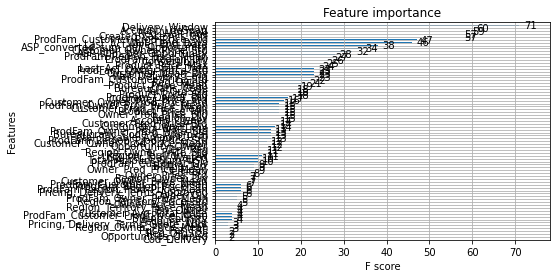

In [287]:
import matplotlib.pyplot as plt

new = xgb.XGBClassifier(objective='binary:logistic', base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

new.fit(X_test,y_test)
plt.figure(figsize=(10, 10))
plot_importance(new)
plt.show()

In [327]:
test_ft = test.loc[:, ['Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
                  'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
                  'Bureaucratic_Code_0_Approved', 'Bureaucratic_Code', 'Billing_Country',
                  'Account_Owner', 'Opportunity_Owner', 'Account_Type',
                  'ASP_sum_per_Opportunity', 'ASP_converted_sum_per_Opportunity', 'Convertibility',
                  'Total_Amount_Sum_USD', 'Total_Taxable_Amount_USD',
                  'Created_Last_Act_Diff', 'Last_Act_Over_End_Date', 'Last_Act_Over_Start_Date', 
                  'Last_Activity_In_Time', 'Wait_Time_Days', 'Delivery_Window', 'Wait_Delivery_Cmp', 
                  'Delivered_Hot_Season', 'USD_Per_Day_Waited', 'Account_LifeSpan', 'Product_Price_Mean', 
                  'Product_Price_Max', 'Product_Price_Std', 'Product_Price_Min', 'Customer_Prod_Price_Mean', 
                  'Customer_Prod_Price_Std', 'Owner_Prod_Price_Mean', 'Owner_Prod_Price_Std', 
                  'Customer_Owner_Prod_Price_Mean', 'Customer_Owner_Prod_Price_Std', 'ProdFam_Owner_Prod_Price_Mean', 
                  'ProdFam_Owner_Prod_Price_Std', 'ProdFam_Region_Prod_Price_Mean', 'ProdFam_Region_Prod_Price_Std', 
                  'ProdFam_Customer_Prod_Price_Mean', 'ProdFam_Customer_Prod_Price_Std', 'Price_Per_TRF', 
                  'Opportunities_Owned', 'Customer_Avg_Total_Price', 'Customer_Price_Std', 'Customer_Mean_Div', 
                  'Owner_Price_Mean', 'Owner_Price_Std', 'Owner_Div', 'Region_Price_Mean', 'Region_Price_Std', 
                  'Region_Div', 'Customer_Owner_Price_Mean', 'Customer_Owner_Price_Std', 'Customer_Owner_Div', 
                  'ProdFam_Owner_Price_Mean', 'ProdFam_Owner_Price_Std', 'ProdFam_Owner_Div', 
                  'ProdFam_Region_Price_Mean', 'ProdFam_Region_Price_Std', 'ProdFam_Region_Div', 
                  'ProdFam_Customer_Price_Mean', 'ProdFam_Customer_Price_Std', 'ProdFam_Customer_Div', 
                  'Region_Territory_Price_Mean', 'Region_Territory_Price_Std', 'Region_Territory_Div', 
                  'Region_Owner_Price_Mean', 'Region_Owner_Price_Std', 'Region_Owner_Div', 
                  'Reg_Owner', 'Terr_Owner', 'Terr_Reg', 'Terr_OrdSize', 'Reg_OrdSize', 'Reg_WaitTime', 'Terr_WaitTime',
                  'Billing_Terr', 'Cod_Delivery']]

pd.DataFrame(random_search.predict_proba(test_ft))
test['Target'] = pd.DataFrame(random_search.predict_proba(test_ft))[1].to_list()
test

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Reg_Owner,Terr_Owner,Terr_Reg,Terr_OrdSize,Reg_OrdSize,Reg_WaitTime,Terr_WaitTime,Billing_Terr,Cod_Delivery,Target
0,6140,0.476287,0.541600,1,1,1,1,0,0.592650,2017-07-05,...,0.265840,0.302295,0.257957,1.624800,1.428860,9.049447,9.049447,0.278357,0.483061,0.858760
3,6118,0.476287,0.541600,1,1,1,1,0,0.592650,2017-07-05,...,0.265840,0.302295,0.257957,2.708000,2.381434,23.814335,23.814335,0.278357,0.483061,0.578218
8,11530,0.466983,0.410034,1,1,0,0,0,0.592650,2019-02-16,...,NaN,NaN,0.191479,0.410034,0.466983,80.321148,80.321148,0.188403,0.544690,0.894754
9,20314,0.466983,0.603414,1,1,1,0,0,0.450971,2013-07-27,...,0.256735,0.331740,0.281784,3.620484,2.801901,113.009987,113.009987,0.277257,0.544690,0.517490
15,7374,0.466983,0.603414,0,0,0,0,0,0.592650,2018-08-30,...,0.282388,0.364889,0.281784,0.603414,0.466983,9.339668,9.339668,0.277257,0.544690,0.976116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,16339,0.476287,0.514128,1,1,0,0,0,0.592650,2017-06-12,...,0.265840,0.286961,0.244872,1.028257,0.952573,2.381434,2.381434,0.266831,0.519072,0.974451
2547,15218,0.466983,0.438631,1,1,0,0,0,0.592650,2018-06-08,...,0.214235,0.201228,0.204833,0.438631,0.466983,73.783380,73.783380,0.201543,0.544690,0.307784
2548,15224,0.466983,0.438631,1,1,1,1,0,0.592650,2018-06-08,...,0.214235,0.201228,0.204833,0.438631,0.466983,73.783380,73.783380,0.201543,0.544690,0.245498
2549,7286,0.466983,0.410034,1,1,0,0,0,0.592650,2018-08-29,...,NaN,NaN,0.191479,0.410034,0.466983,45.297392,45.297392,0.188403,0.544690,0.899231


In [328]:
test.loc[:, ['Opportunity_ID', 'Target']].to_csv('submission.csv', index=False)

In [75]:
random_search.feature_importances_

AttributeError: 'RandomizedSearchCV' object has no attribute 'feature_importances_'